In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
import os
from zipfile import ZipFile
import kaggle

# Set environment variable (if needed)
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Download dataset
!kaggle datasets download -d sumn2u/garbage-classification-v2

# Extract the dataset
with ZipFile("garbage-classification-v2.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")


Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 96% 717M/744M [00:07<00:00, 171MB/s]
100% 744M/744M [00:07<00:00, 100MB/s]


In [ ]:
import zipfile

# Path to the downloaded zip
zip_path = "/content/garbage-classification-v2.zip"
extract_to = "/content/garbage_dataset"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset extracted.")


✅ Dataset extracted.


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import math


In [ ]:
image_dir = "/content/garbage_dataset/garbage-dataset"
class_names = sorted(os.listdir(image_dir))


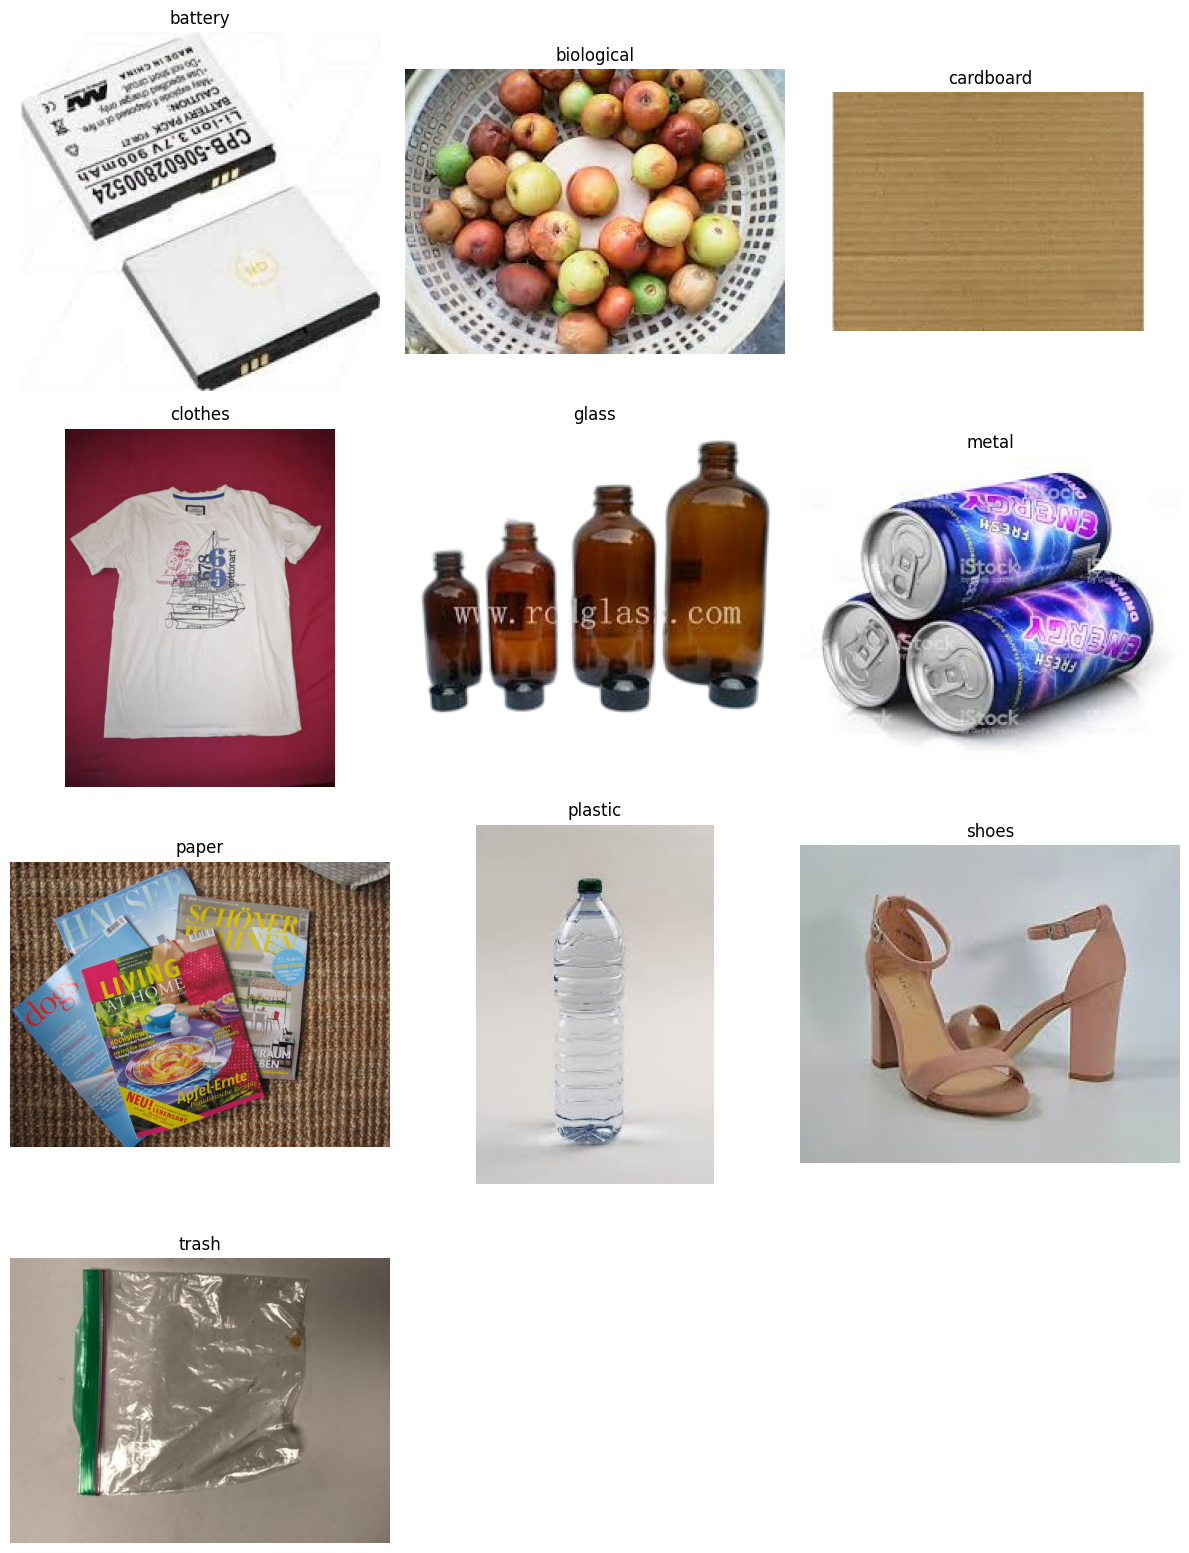

In [ ]:
num_classes = len(class_names)
cols = 3
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(cols * 4, rows * 4))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(image_dir, class_name)
    image_file = random.choice(os.listdir(class_path))
    image = Image.open(os.path.join(class_path, image_file))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("Detected classes:", class_names)
print("Total:", len(class_names))

Detected classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Total: 10


In [ ]:
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
source_dir = "/content/garbage_dataset/garbage-dataset"
dest_dir = "/content/split_garbage"

In [ ]:
splits = ['train', 'val', 'test']
for split in splits:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

In [ ]:
# Loop through each class and split images
for class_name in tqdm(os.listdir(source_dir), desc="Processing classes"):
    class_path = os.path.join(source_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Train-test split
    train_val, test = train_test_split(images, test_size=0.1, random_state=42)
    train, val = train_test_split(train_val, test_size=2/9, random_state=42)  # 0.2 / 0.9 ≈ 2/9

    split_map = {
        'train': train,
        'val': val,
        'test': test
    }


    for split, file_list in split_map.items():
        for filename in file_list:
            src = os.path.join(class_path, filename)
            dst = os.path.join(dest_dir, split, class_name, filename)
            shutil.copy2(src, dst)

print("✅ Done! Data split into train, val, and test")

Processing classes: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

✅ Done! Data split into train, val, and test


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:

data_dir = "/content/split_garbage"
img_size = (224, 224)
batch_size = 32
num_classes = 10

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [ ]:

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 13827 images belonging to 10 classes.
Found 3955 images belonging to 10 classes.
Found 1980 images belonging to 10 classes.


In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ✅ Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_mobilenetv2_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# ✅ Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7501 - loss: 0.7749
Epoch 1: val_loss improved from inf to 0.31179, saving model to best_mobilenetv2_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 248s 529ms/step - accuracy: 0.7503 - loss: 0.7744 - val_accuracy: 0.9016 - val_loss: 0.3118
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8832 - loss: 0.3504
Epoch 2: val_loss improved from 0.31179 to 0.28154, saving model to best_mobilenetv2_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 242s 505ms/step - accuracy: 0.8832 - loss: 0.3503 - val_accuracy: 0.9102 - val_loss: 0.2815
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8979 - loss: 0.3026
Epoch 3: val_loss improved from 0.28154 to 0.25457, saving model to best_mobilenetv2_model.h5


433/433 ━━━━━━━━━━━━━━━━━━━━ 216s 498ms/step - accuracy: 0.8979 - loss: 0.3026 - val_accuracy: 0.9198 - val_loss: 0.2546
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9195 - loss: 0.2454
Epoch 4: val_loss did not improve from 0.25457
433/433 ━━━━━━━━━━━━━━━━━━━━ 213s 492ms/step - accuracy: 0.9195 - loss: 0.2454 - val_accuracy: 0.9161 - val_loss: 0.2620
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9276 - loss: 0.2100
Epoch 5: val_loss did not improve from 0.25457
433/433 ━━━━━━━━━━━━━━━━━━━━ 210s 484ms/step - accuracy: 0.9276 - loss: 0.2101 - val_accuracy: 0.9204 - val_loss: 0.2567
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9246 - loss: 0.2136
Epoch 6: val_loss did not improve from 0.25457
433/433 ━━━━━━━━━━━━━━━━━━━━ 210s 486ms/step - accuracy: 0.9246 - loss: 0.2136 - val_accuracy: 0.9181 - val_loss: 0.2714
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
#  Evaluate on test set
loss, acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {acc:.2%}")

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9351 - loss: 0.2133

In [ ]:
model.save("mobilenetv2_waste_classifier_final.h5")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
# Predict
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print(classification_report(y_true, y_pred_labels, target_names=class_labels))

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
img_path = '/content/fruit.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
pred = model.predict(img_array)
pred_class = class_labels[np.argmax(pred)]

print(f"♻️ Predicted class: {pred_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
♻️ Predicted class: biological


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


<Figure size 1000x800 with 0 Axes>

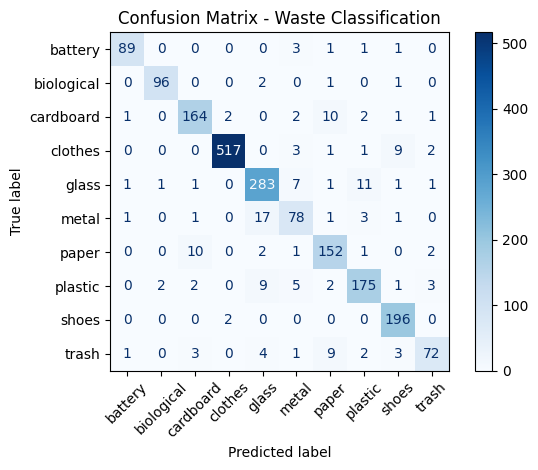

In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Waste Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
files.download("mobilenetv2_waste_classifier_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>